## Driver code comparing output of different atlas / parcellations 

### Steps
- import data csvs from different atlases
- compare performance of machine-learning model (scikit-learn)
- compare performance of statsmodels (ols or logit)

In [1]:
import sys
import numpy as np
import pandas as pd
import itertools

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time

sys.path.append('../')
from lib.data_handling import *
from lib.data_stats import *

### Data paths

In [2]:
proj_dir = '/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/'
data_dir = proj_dir + 'data/'
results_dir = data_dir + 'results/'
qc_dir =  '/home/nikhil/projects/CT_reproduce/data/QC/'
outlier_dir = data_dir + 'outliers/'
fs60_dir = data_dir + 'fs60_group_stats/'
demograph_file = 'ABIDE_Phenotype.csv'

#fs60 all files
# Thickness
fs60_aparc_lh_thickness_file = 'lh.aparc.thickness.table.test1'
fs60_aparc_rh_thickness_file = 'rh.aparc.thickness.table.test1' #34 ROIs
fs60_aparc2009_lh_thickness_file = 'lh.aparc.a2009.thickness.table.test1' #74 ROIs per hemi
fs60_aparc2009_rh_thickness_file = 'rh.aparc.a2009.thickness.table.test1'
fs60_glasser_lh_thickness_file = 'lh.glasser.thickness.table.test1' #180 ROIs per hemi
fs60_glasser_rh_thickness_file = 'rh.glasser.thickness.table.test1'

#outlier files
aparc_outlier_file = 'aparc_outlier_data.csv'
destr_outlier_file = 'des_outlier_data.csv'
glass_outlier_file = 'glas_outlier_data.csv'

### Global Vars

In [3]:
subject_ID_col = 'SubjID'

### Load data

In [4]:
# Demographics and Dx
demograph = pd.read_csv(data_dir + demograph_file)
demograph = demograph.rename(columns={'Subject_ID':subject_ID_col})

# aparc
aparc = 'aparc'
fs60_aparc_lh_thickness_data = pd.read_csv(fs60_dir + fs60_aparc_lh_thickness_file, delim_whitespace=True)
fs60_aparc_rh_thickness_data = pd.read_csv(fs60_dir + fs60_aparc_rh_thickness_file, delim_whitespace=True)
print('shape of fs60 aparc data l: {}, r: {}'.format(fs60_aparc_lh_thickness_data.shape,fs60_aparc_rh_thickness_data.shape))
fs60_aparc_thickness_data_std = standardize_fs60_data(fs60_aparc_lh_thickness_data, 
                                                      fs60_aparc_rh_thickness_data, subject_ID_col, aparc)
print('shape of stdized fs60 aparc data {}'.format(fs60_aparc_thickness_data_std.shape))


# Destrieux
aparc = 'aparc.a2009s'
fs60_aparc2009_lh_thickness_data = pd.read_csv(fs60_dir + fs60_aparc2009_lh_thickness_file, delim_whitespace=True)
fs60_aparc2009_rh_thickness_data = pd.read_csv(fs60_dir + fs60_aparc2009_rh_thickness_file, delim_whitespace=True)
print('shape of fs60 aparc2009 data l: {}, r: {}'.format(fs60_aparc2009_lh_thickness_data.shape,fs60_aparc2009_rh_thickness_data.shape))
fs60_aparc2009_thickness_data_std = standardize_fs60_data(fs60_aparc2009_lh_thickness_data,
                                                          fs60_aparc2009_rh_thickness_data, subject_ID_col, aparc)
print('shape of stdized fs60 aparc data {}'.format(fs60_aparc2009_thickness_data_std.shape))


# Glasser
aparc = 'aparc.Glasseratlas'
fs60_glasser_lh_thickness_data = pd.read_csv(fs60_dir + fs60_glasser_lh_thickness_file, delim_whitespace=True)
fs60_glasser_rh_thickness_data = pd.read_csv(fs60_dir + fs60_glasser_rh_thickness_file, delim_whitespace=True)
print('shape of fs60 glasser data l: {}, r: {}'.format(fs60_glasser_lh_thickness_data.shape,fs60_glasser_rh_thickness_data.shape))
fs60_glasser_thickness_data_std = standardize_fs60_data(fs60_glasser_lh_thickness_data,
                                                          fs60_glasser_rh_thickness_data, subject_ID_col, aparc)
print('shape of stdized fs60 aparc data {}'.format(fs60_glasser_thickness_data_std.shape))


shape of fs60 aparc data l: (1047, 36), r: (1047, 36)
shape of left and right merge fs6.0 df (1047, 71)
shape of stdized fs60 aparc data (1047, 71)
shape of fs60 aparc2009 data l: (1047, 76), r: (1047, 76)
shape of left and right merge fs6.0 df (1047, 151)
shape of stdized fs60 aparc data (1047, 151)
shape of fs60 glasser data l: (1047, 182), r: (1047, 182)
shape of left and right merge fs6.0 df (1047, 363)
shape of stdized fs60 aparc data (1047, 363)


### Create master dataframe

In [5]:
data_dict = {'aparc' : fs60_aparc_thickness_data_std,
            'Destrieux' : fs60_aparc2009_thickness_data_std,
            'Glasser' : fs60_glasser_thickness_data_std}

outlier_file_dict = {'aparc' : aparc_outlier_file,
            'Destrieux' : destr_outlier_file,
            'Glasser' : glass_outlier_file}

# Add demographic columns to the master_df
useful_demograph = demograph[[subject_ID_col,'SEX','AGE_AT_SCAN','DX_GROUP','SITE_ID']].copy()

# Replace to (2 with 0 for statsmodels) (1:ASD, 0:Controls)
useful_demograph['DX_GROUP'] = useful_demograph['DX_GROUP'].replace({2:0})
useful_demograph['SEX'] = useful_demograph['SEX']-1

_,useful_demograph[subject_ID_col] = useful_demograph[subject_ID_col].str.rsplit('_', 1).str

### Compare ML performance 

In [40]:
model_type = 'regression'
n_workflow = 1 #Analyzing each atlas separately
qc_list = ['No_QC','manual_maarten','manual_gleb','auto']
ml_perf_concat = pd.DataFrame()
perf_pval_dict = {}
start_time_ML = time.time()

for atlas in data_dict.keys():
    start_time_atlas = time.time()
    print('\nAtlas {}'.format(atlas))
    master_df_raw = pd.merge(useful_demograph,data_dict[atlas],on= subject_ID_col)

    # For each atlas create a dictionary df
    for qc in qc_list:
        if qc == 'No_QC':
            print('No QC applied')
            filtered_df = master_df_raw
            filtered_subs = filtered_df[subject_ID_col].unique()
            print('Resultant number of subjects {}'.format(len(filtered_subs)))
        else:            
            if qc == 'manual_maarten':
                qc_df = pd.read_csv(qc_dir + 'master_QC_table.csv',dtype={'SubjID': int})
                qc_criterion = ('QC_maarten',[0]) # keep subs
            elif qc == 'manual_gleb':
                qc_df = pd.read_csv(qc_dir + 'master_QC_table.csv',dtype={'SubjID': int})
                qc_criterion = ('QC_gleb',['1','-+1']) # keep subs
            elif qc == 'auto':
                outlier_file = outlier_file_dict[atlas]
                qc_df = pd.read_csv(outlier_dir + outlier_file,dtype={'SubjID': int})
                qc_criterion = ('outlier_all_data',[0])    
            else:
                print('Unknow QC type')

            # Subjects you want to keep based on other crieria for sample size purposes
            external_criterion = {'SITE_ID':3*n_workflow}
            filtered_df = filter_data(master_df_raw, subject_ID_col, qc_df, qc_criterion, external_criterion)
            
        master_df = filtered_df
        
        # Need to append Dx based performance separately for now
        # Since using scikit learn defined cross-val-score
        for dx_grp in [0,1]:
            print('Starting ML models for atlas {} qc {} dx {}'.format(atlas,qc,dx_grp))
            if model_type.lower() == 'regression':
                outcome_col = 'AGE_AT_SCAN'
                covar_continuous_cols = []
                covar_cat_cols = ['SEX','SITE_ID','DX_GROUP']

                model = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=50)
            else: 
                outcome_col = 'DX_GROUP'
                covar_continuous_cols = ['AGE_AT_SCAN']
                covar_cat_cols = ['SEX','SITE_ID']

                #model = svm.SVC(kernel='linear')
                model = RandomForestClassifier(n_estimators=50, max_depth=2,random_state=0)

            # Compute Dx based performance separately for now
            # Since using scikit learn defined cross-val-score
            ml_master_df = master_df[master_df['DX_GROUP']==dx_grp]
            roi_cols = master_df.filter(regex='^L|R_', axis=1).columns
            ml_perf, null_df, pvalue = getMLModelPerf(ml_master_df,roi_cols, covar_continuous_cols,covar_cat_cols,outcome_col,model_type,model)
            
            ml_perf['atlas'] = np.tile(atlas,len(ml_perf))
            null_df['atlas'] = np.tile('null',len(null_df))
            ml_perf['qc'] = np.tile(qc,len(ml_perf))
            null_df['qc'] = np.tile(qc,len(null_df))
            ml_perf['DX_GROUP'] = np.tile(dx_grp,len(ml_perf))
            null_df['DX_GROUP'] = np.tile(dx_grp,len(null_df))
            ml_perf_concat = ml_perf_concat.append(ml_perf).append(null_df)
            perf_pval_dict[atlas] = pvalue
            
    print('time to process atlas {:4.3f}m \n'.format((time.time()-start_time_atlas)/60.0))
print('time to process ML {:4.3}m'.format((time.time()-start_time_ML)/60.0))



Atlas Destrieux
No QC applied
Resultant number of subjects 1047
Starting ML models for atlas Destrieux qc No_QC dx 0
Using 3 col for 22 cat covar
Data shapes X (552, 170), y 552 (16.97m, 7.51sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-29.828, sd:9.004
Starting ML models for atlas Destrieux qc No_QC dx 1
Using 3 col for 22 cat covar
Data shapes X (495, 170), y 495 (17.11m, 8.43sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-39.229, sd:15.115

Filtering based on QC_maarten. Number subjects before filtering 1047
Resultant number of subjects 975
Filtering based on external crierion
Performing min sample (N_min=3) per workflow size check based on SITE_ID
Dropping subjects for all workflows for SITE_ID Series([], Name: SITE_ID, dtype: int64)
Resultant number of subjects 975
Starting ML models for atlas Destrieux qc manual_maarten dx 0
Using 3 col for 22 cat covar
Data shapes X (525, 170), y 525 (17.08m, 7.51sd)
Using regressi

 Perf mean:-19.252, sd:4.841
Starting ML models for atlas Glasser qc auto dx 1
Using 3 col for 22 cat covar
Data shapes X (448, 382), y 448 (15.03m, 5.14sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-16.903, sd:4.266
time to process atlas 10.907m 

time to process ML 17.9m


In [41]:
ml_perf_concat['atlas'].value_counts()

aparc        800
Destrieux    800
Glasser      800
null         240
Name: atlas, dtype: int64

{'Destrieux': 0.09090909090909091, 'aparc': 0.09090909090909091, 'Glasser': 0.09090909090909091}


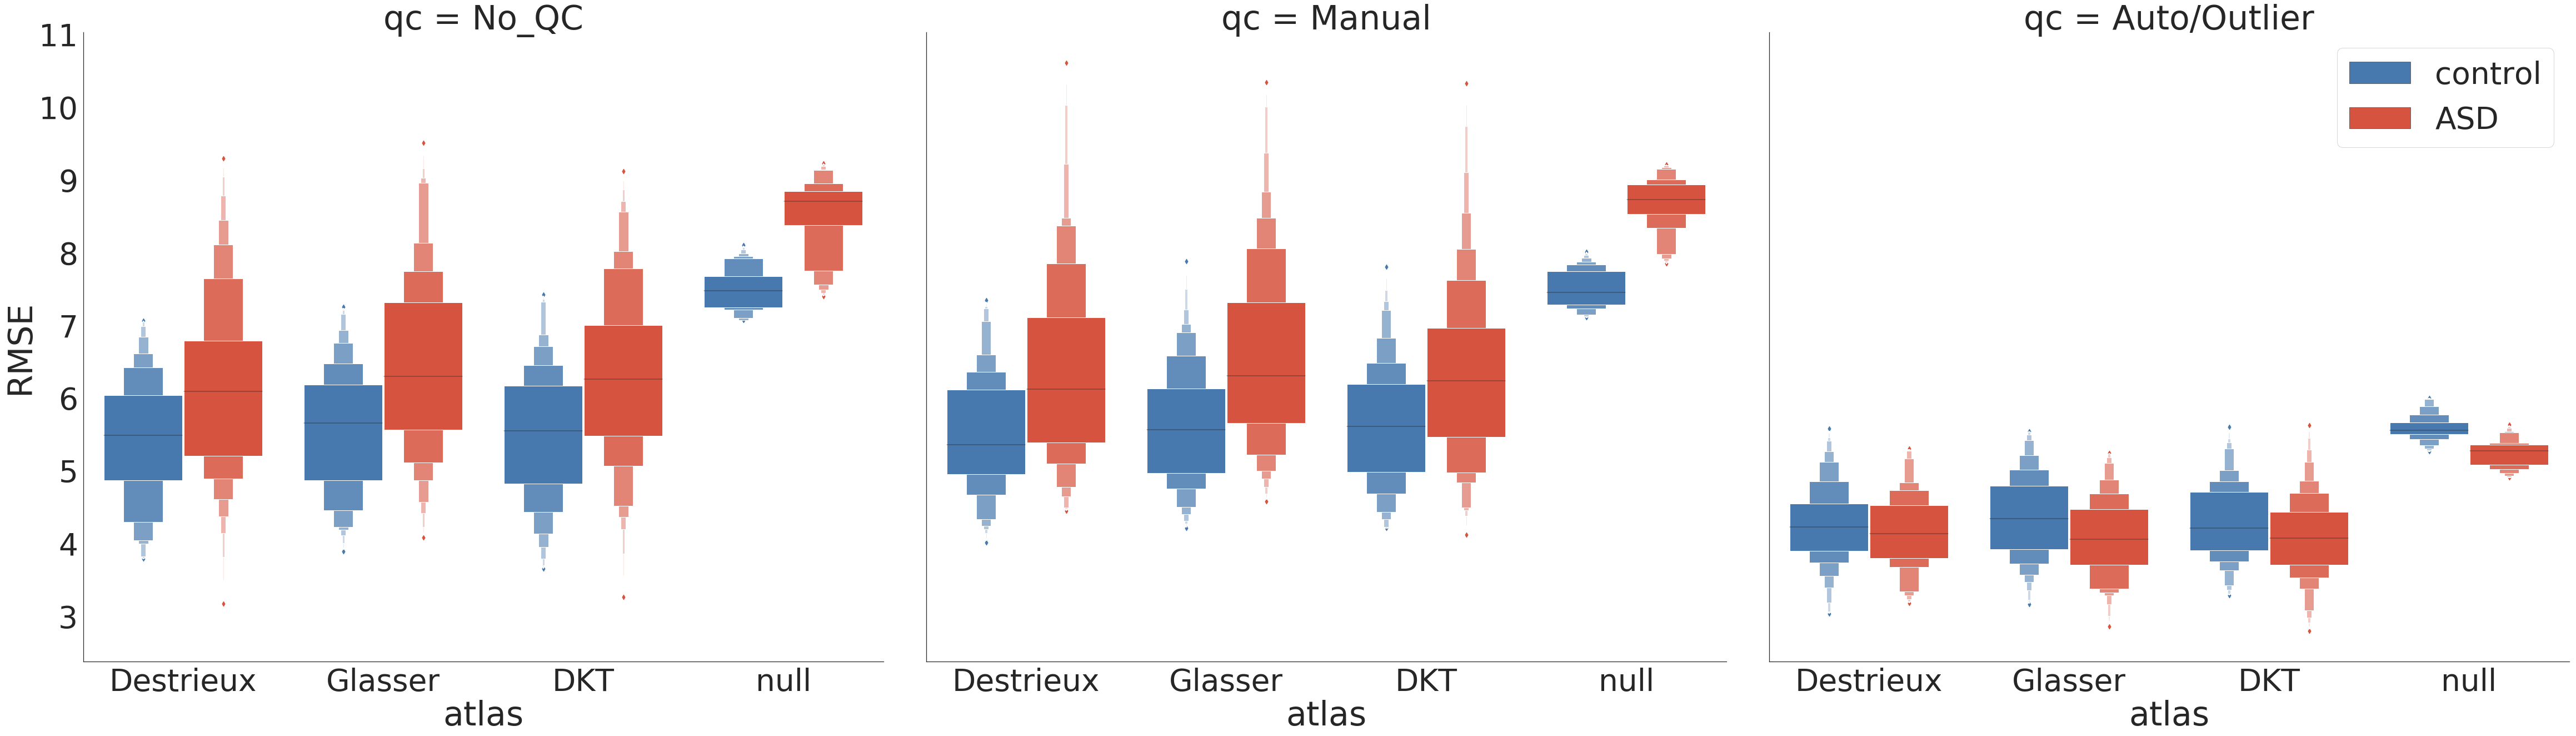

In [74]:
print(perf_pval_dict)
plot_df = ml_perf_concat.copy()
plot_df['RMSE'] = np.sqrt(-1*plot_df['neg_mean_squared_error'])
plot_df['DX_GROUP'] = plot_df['DX_GROUP'].replace({0:'control', 1:'ASD'})
plot_df['atlas'] = plot_df['atlas'].replace({'aparc':'DKT'})
plot_df['qc'] = plot_df['qc'].replace({'manual_maarten':'Manual', 'auto':'Auto/Outlier'})

x_order = ['Destrieux','Glasser','DKT','null']
col_order = ['No_QC','Manual','Auto/Outlier']
colors = ["windows blue", "tomato", "greyish", "faded green", "dusty purple"]
sns.set(font_scale=5)
with sns.axes_style("white"): 
    g = sns.catplot(y='RMSE',x='atlas',kind='boxen',hue='DX_GROUP',col='qc',data=plot_df, legend=False,
                    order=x_order, col_order=col_order, palette=sns.xkcd_palette(colors), height=20, aspect=1.1 )
    plt.legend(loc='upper right')
    


### Compare statsmodels performance 

In [96]:
covar_cols = [('AGE_AT_SCAN','continuous'),('SEX','cat'),('SITE_ID','cat')]
outcome_col = ('DX_GROUP','cat') #'roi' #AGE_AT_SCAN #DX_GROUP 
signific_col = ('roi','continuous') #('DX_GROUP','cat'),('roi','continuous') 
stat_model = 'logit' #ols #logit

save_sm_perf = True
n_workflow = 1 #Analyzing each atlas separately
qc_list = ['No_QC','manual_maarten','manual_gleb','auto']

for qc in qc_list:
    # For each atlas create a dictionary df
    stat_perf_dict = {}
    for atlas in data_dict.keys():
        start_time_atlas = time.time()
        print('\nAtlas {}'.format(atlas))
        
        mr_data_df = data_dict[atlas]
        roi_cols = list(mr_data_df.filter(regex='^L|R_', axis=1).columns)
        master_df_raw = pd.merge(useful_demograph,mr_data_df[[subject_ID_col]+ roi_cols],on=subject_ID_col)
    
        if qc == 'No_QC':
            print('No QC applied')
            filtered_df = master_df_raw
            filtered_subs = filtered_df[subject_ID_col].unique()
            print('Resultant number of subjects {}'.format(len(filtered_subs)))
        else:            
            if qc == 'manual_maarten':
                qc_df = pd.read_csv(qc_dir + 'master_QC_table.csv',dtype={'SubjID': int})
                qc_criterion = ('QC_maarten',[0]) # keep subs
            elif qc == 'manual_gleb':
                qc_df = pd.read_csv(qc_dir + 'master_QC_table.csv',dtype={'SubjID': int})
                qc_criterion = ('QC_gleb',['1','-+1']) # keep subs
            elif qc == 'auto':
                outlier_file = outlier_file_dict[atlas]
                qc_df = pd.read_csv(outlier_dir + outlier_file,dtype={'SubjID': int})
                qc_criterion = ('outlier_all_data',[0])    
            else:
                print('Unknow QC type')

            # Subjects you want to keep based on other crieria for sample size purposes
            external_criterion = {'SITE_ID':4*n_workflow}
            filtered_df = filter_data(master_df_raw, subject_ID_col, qc_df, qc_criterion, external_criterion)
            
        master_df = filtered_df
    
        master_df['atlas'] = np.tile(atlas,len(master_df))
        common_subs = master_df[subject_ID_col].unique()
        
        sm_perf = getStatModelPerf(master_df,roi_cols,covar_cols,outcome_col,signific_col,stat_model)
        
        print('Shape of the stats_models results df {}'.format(sm_perf.shape))
        print('Top 5 significant regions:\n {}'.format(sm_perf.sort_values(by=['p_val']).head(5)))
        print('')
        stat_perf_dict[atlas] = sm_perf
        
    if save_sm_perf:
        save_path = '{}atlas_sm_perf_sanitycheck_{}_{}_{}_QC_{}_N_{}.pkl'.format(results_dir,outcome_col[0],signific_col[0],stat_model,qc,len(common_subs))
        print('Saving sm_perf dictionary at \n{}'.format(save_path))
        with open(save_path, 'wb') as handle:
            pickle.dump(stat_perf_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)



Atlas Destrieux
No QC applied
Resultant number of subjects 1047
Example statsmodel run:
 DX_GROUP ~ R_S_temporal_transverse + AGE_AT_SCAN + C(SEX) + C(SITE_ID)
Shape of the stats_models results df (148, 5)
Top 5 significant regions:
                          roi      coef     t_val     p_val  p_val_corr
115         R_Pole_occipital  1.992120  4.750595  0.000002    0.000300
41          L_Pole_occipital  1.536966  4.305179  0.000017    0.001235
21   L_G_oc_temp_med_Lingual  1.543737  3.829732  0.000128    0.004337
43             L_S_calcarine  1.663708  3.819917  0.000133    0.004337
10                L_G_cuneus  1.461462  3.796898  0.000147    0.004337


Atlas aparc
No QC applied
Resultant number of subjects 1047
Example statsmodel run:
 DX_GROUP ~ R_insula + AGE_AT_SCAN + C(SEX) + C(SITE_ID)
Shape of the stats_models results df (68, 5)
Top 5 significant regions:
                       roi      coef     t_val     p_val  p_val_corr
45              R_lingual  1.729150  3.640070  0.000273

Example statsmodel run:
 DX_GROUP ~ R_S_temporal_transverse + AGE_AT_SCAN + C(SEX) + C(SITE_ID)
Shape of the stats_models results df (148, 5)
Top 5 significant regions:
                          roi      coef     t_val     p_val  p_val_corr
115         R_Pole_occipital  1.836775  4.224256  0.000024    0.003548
41          L_Pole_occipital  1.374505  3.750945  0.000176    0.013037
43             L_S_calcarine  1.405323  3.102489  0.001919    0.073202
103            R_G_precuneus -1.289662 -3.003908  0.002665    0.073202
21   L_G_oc_temp_med_Lingual  1.231922  2.954841  0.003128    0.073202


Atlas aparc

Filtering based on outlier_all_data. Number subjects before filtering 1047
Resultant number of subjects 961
Filtering based on external crierion
Performing min sample (N_min=4) per workflow size check based on SITE_ID
Dropping subjects for all workflows for SITE_ID SBL    3
Name: SITE_ID, dtype: int64
Resultant number of subjects 958
Example statsmodel run:
 DX_GROUP ~ R_insula + AGE_AT

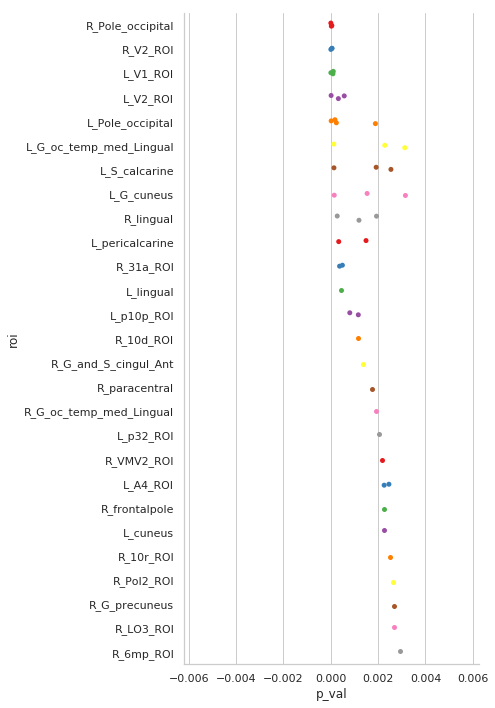

In [82]:
# Plots
aparc = 'Glasser' #'Destrieux', 'aparc','Glasser'
top_rois = 50
plot_df = stat_perf_dict[aparc].sort_values(by=['p_val']).head(top_rois)

sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='p_val',y='roi',kind='strip',
                    data=plot_df,palette='Set1',height=10,aspect=0.7)
    #g.set(xscale="log");

In [95]:
roi_cols

['L_V1_ROI',
 'L_MST_ROI',
 'L_V6_ROI',
 'L_V2_ROI',
 'L_V3_ROI',
 'L_V4_ROI',
 'L_V8_ROI',
 'L_4_ROI',
 'L_3b_ROI',
 'L_FEF_ROI',
 'L_PEF_ROI',
 'L_55b_ROI',
 'L_V3A_ROI',
 'L_RSC_ROI',
 'L_POS2_ROI',
 'L_V7_ROI',
 'L_IPS1_ROI',
 'L_FFC_ROI',
 'L_V3B_ROI',
 'L_LO1_ROI',
 'L_LO2_ROI',
 'L_PIT_ROI',
 'L_MT_ROI',
 'L_A1_ROI',
 'L_PSL_ROI',
 'L_SFL_ROI',
 'L_PCV_ROI',
 'L_STV_ROI',
 'L_7Pm_ROI',
 'L_7m_ROI',
 'L_POS1_ROI',
 'L_23d_ROI',
 'L_v23ab_ROI',
 'L_d23ab_ROI',
 'L_31pv_ROI',
 'L_5m_ROI',
 'L_5mv_ROI',
 'L_23c_ROI',
 'L_5L_ROI',
 'L_24dd_ROI',
 'L_24dv_ROI',
 'L_7AL_ROI',
 'L_SCEF_ROI',
 'L_6ma_ROI',
 'L_7Am_ROI',
 'L_7PL_ROI',
 'L_7PC_ROI',
 'L_LIPv_ROI',
 'L_VIP_ROI',
 'L_MIP_ROI',
 'L_1_ROI',
 'L_2_ROI',
 'L_3a_ROI',
 'L_6d_ROI',
 'L_6mp_ROI',
 'L_6v_ROI',
 'L_p24pr_ROI',
 'L_33pr_ROI',
 'L_a24pr_ROI',
 'L_p32pr_ROI',
 'L_a24_ROI',
 'L_d32_ROI',
 'L_8BM_ROI',
 'L_p32_ROI',
 'L_10r_ROI',
 'L_47m_ROI',
 'L_8Av_ROI',
 'L_8Ad_ROI',
 'L_9m_ROI',
 'L_8BL_ROI',
 'L_9p_ROI',
 'L_10d_ROI